# Audio compression with EnCodec and OpenVINO

Compression is an important part of the Internet today because it enables people to easily share high-quality photos, listen to audio messages, stream their favorite shows, and so much more. Even when using today’s state-of-the-art techniques, enjoying these rich multimedia experiences requires a high speed Internet connection and plenty of storage space. AI helps to overcome these limitations: "Imagine listening to a friend’s audio message in an area with low connectivity and not having it stall or glitch."

This tutorial considers ways to use OpenVINO and EnCodec algorithm for hyper compression of audio.
EnCodec is a real-time, high-fidelity audio codec that uses AI to compress audio files without losing quality. It was introduced in [High Fidelity Neural Audio Compression](https://arxiv.org/pdf/2210.13438.pdf) paper by Meta AI. The researchers claimed they achieved an approximate 10x compression rate without loss of quality and made it work for CD-quality audio. More details about this approach can be found in [Meta AI blog](https://ai.facebook.com/blog/ai-powered-audio-compression-technique/) and original [repo](https://github.com/facebookresearch/encodec).

![image.png](https://scontent-lhr8-2.xx.fbcdn.net/v/t39.2365-6/312601754_5499426036839537_5020909861634924715_n.png?_nc_cat=105&ccb=1-7&_nc_sid=ad8a9d&_nc_ohc=gxrGtelmH20AX_RSYaG&_nc_ht=scontent-lhr8-2.xx&oh=00_AfAZ8lx0weFXoKzGUC8FGmdcBswQxmZnpFLTFEBIdeIXLg&oe=6401ABBD)


## Prerequisites

Install required dependencies:

In [1]:
!python -W ignore -m pip install -q -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Instantiate audio compression pipeline

[Codecs](https://en.wikipedia.org/wiki/Codec), which act as encoders and decoders for streams of data, help empower most of the audio compression people currently use online. Some examples of commonly used codecs include MP3, Opus, and EVS. Classic codecs like these decompose the signal between different frequencies and encode as efficiently as possible. Most classic codecs leverage human hearing knowledge (psychoacoustics) but have a finite or given set of handcrafted ways to efficiently encode and decode the file. EnCodec, a neural network that is trained from end to end to reconstruct the input signal, was introduced as an attempt to overcome this limitation. It consists of three parts:

* The **encoder**, which takes the uncompressed data in and transforms it into a higher dimensional and lower frame rate representation.

* The **quantizer**, which compresses this representation to the target size. This compressed representation is what is stored on disk or will be sent through the network.

* The **decoder** is the final step. It turns the compressed signal back into a waveform that is as similar as possible to the original. The key to lossless compression is to identify changes that will not be perceivable by humans, as perfect reconstruction is impossible at low bit rates.

![encodec_compression](https://scontent-lhr8-1.xx.fbcdn.net/v/t39.2365-6/312631767_820469602333729_4265486792384109107_n.png?_nc_cat=108&ccb=1-7&_nc_sid=ad8a9d&_nc_ohc=92B-ND5hEs0AX_ALCwD&_nc_ht=scontent-lhr8-1.xx&oh=00_AfDN4ggNCYyPVGXEZKG6F8rZ_TP0_NFhUcG7Z2n8FdqEtg&oe=64016841)


The authors provide two multi-bandwidth models:
* `encodec_model_24khz` - a causal model operating at 24 kHz on monophonic audio trained on a variety of audio data.
* `encodec_model_48khz` - a non-causal model operating at 48 kHz on stereophonic audio trained on music-only data.

In this tutorial, we will use `encodec_model_24khz` as an example, but the same actions are also applicable to `encodec_model_48khz` model as well.
To start working with this model, we need to instantiate model class using EncodecModel.encodec_model_24khz() and select required compression bandwidth among available: 1.5, 3, 6, 12 or 24 kbps for 24 kHz model and 3, 6, 12 and 24 kbps for 48 kHz model. We will use 6 kbs bandwidth.

In [2]:
from encodec import EncodecModel
from encodec.utils import convert_audio
import torchaudio
import torch

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)

## Explore EnCodec pipeline

Let us explore model capabilities on example audio:

'test_24k.wav' already exists.


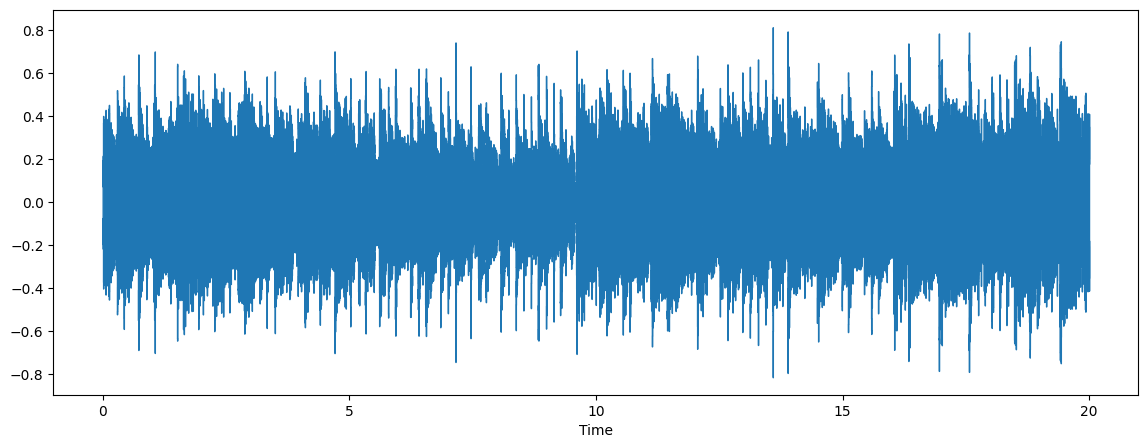

In [3]:
import sys
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

sys.path.append("../utils")

from notebook_utils import download_file

test_data_url = "https://github.com/facebookresearch/encodec/raw/main/test_24k.wav"

sample_file = 'test_24k.wav'
download_file(test_data_url, sample_file)
audio, sr = librosa.load(sample_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)

ipd.Audio(sample_file)

### Preprocessing

To achieve the best result, audio should have the number of channels and sample rate expected by the model. If audio does not fulfill these requirements, it can be converted to the desired sample rate and the number of channels using the `convert_audio` function.

In [4]:
model_sr, model_channels = model.sample_rate, model.channels
print(f"Model expected sample rate {model_sr}")
print(f"Model expected audio format {'mono' if model_channels == 1 else 'stereo'}")

Model expected sample rate 24000
Model expected audio format mono


In [5]:
# Load and pre-process the audio waveform
wav, sr = torchaudio.load(sample_file)
wav = convert_audio(wav, sr, model_sr, model_channels)
# Add batch dimension to audio
wav = wav.unsqueeze(0)

### Encoding

Audio waveform should be split by chunks and then encoded by Encoder model, then compressed by quantizer for reducing memory. The result of compression is a binary file with `ecdc` extension, a special format for storing EnCodec compressed audio on disc.

In [6]:
import io
import typing as tp
import math
from encodec import binary
from encodec.quantization.ac import ArithmeticCoder, ArithmeticDecoder, build_stable_quantized_cdf


def compress_to_file(model: EncodecModel, wav: torch.Tensor, fo: tp.IO[bytes],
                     use_lm: bool = False):
    """Compress a waveform to a file-object using the given model.
    Args:
        model (EncodecModel): a pre-trained EncodecModel to use to compress the audio.
        wav (torch.Tensor): waveform to compress, should have a shape `[C, T]`, with `C`
            matching `model.channels`, and the proper sample rate (e.g. `model.sample_rate`).
            Use `convert_audio` if this is not the case.
        fo (IO[bytes]): file-object to which the compressed bits will be written.
        use_lm (bool): if True, use a pre-trained language model to further
            compress the stream using Entropy Coding. This will slow down compression
            quite a bit, expect between 20 to 30% of size reduction.
    """

    if use_lm:
        lm = model.get_lm_model()

    with torch.no_grad():
        frames = model.encode(wav)

    metadata = {
        'm': model.name,                 # model name
        'al': wav.shape[-1],             # audio_length
        'nc': frames[0][0].shape[1],     # num_codebooks
        'lm': use_lm,                    # use lm?
    }
    binary.write_ecdc_header(fo, metadata)

    for (frame, scale) in frames:
        if scale is not None:
            fo.write(struct.pack('!f', scale.cpu().item()))
        _, K, T = frame.shape
        if use_lm:
            coder = ArithmeticCoder(fo)
            states: tp.Any = None
            offset = 0
            input_ = torch.zeros(1, K, 1, dtype=torch.long, device=wav.device)
        else:
            packer = binary.BitPacker(model.bits_per_codebook, fo)
        for t in range(T):
            if use_lm:
                with torch.no_grad():
                    probas, states, offset = lm(input_, states, offset)
                input_ = 1 + frame[:, :, t: t + 1]
            for k, value in enumerate(frame[0, :, t].tolist()):
                if use_lm:
                    q_cdf = build_stable_quantized_cdf(
                        probas[0, :, k, 0], coder.total_range_bits, check=False)
                    coder.push(value, q_cdf)
                else:
                    packer.push(value)
        if use_lm:
            coder.flush()
        else:
            packer.flush()

In [7]:
from pathlib import Path

fo = io.BytesIO()
out_file = Path("compressed.ecdc")
compress_to_file(model, wav, fo)
out_file.write_bytes(fo.getvalue())

15067

Let us compare obtained compression result:

In [8]:
import os

orig_file_stats = os.stat(sample_file)
compressed_file_stats = os.stat("compressed.ecdc")
print(f"size before compression in Bytes: {orig_file_stats.st_size}")
print(f"size after compression in Bytes: {compressed_file_stats.st_size}")
print(f"Compression file size ratio: {orig_file_stats.st_size / compressed_file_stats.st_size:.2f}")

size before compression in Bytes: 960078
size after compression in Bytes: 15067
Compression file size ratio: 63.72


Great! Now, we see the power of hyper compression. Binary size of a file becomes 60 times smaller and more suitable for sending via network.

### Decompression

After successful sending of the compressed audio, it should be decompressed on the recipient's side. The decoder model is responsible for restoring the compressed signal back into a waveform that is as similar as possible to the original.

In [9]:
def decompress_from_file(fo: tp.IO[bytes]) -> tp.Tuple[torch.Tensor, int]:
    """Decompress from a file-object.
    Returns a tuple `(wav, sample_rate)`.
    Args:
        fo (IO[bytes]): file-object from which to read.
    """
    metadata = binary.read_ecdc_header(fo)
    audio_length = metadata['al']
    num_codebooks = metadata['nc']
    use_lm = metadata['lm']

    if use_lm:
        lm = model.get_lm_model()

    frames: tp.List[EncodedFrame] = []
    segment_length = model.segment_length or audio_length
    segment_stride = model.segment_stride or audio_length
    for offset in range(0, audio_length, segment_stride):
        this_segment_length = min(audio_length - offset, segment_length)
        frame_length = int(math.ceil(this_segment_length / model.sample_rate * model.frame_rate))
        if model.normalize:
            scale_f, = struct.unpack('!f', binary._read_exactly(fo, struct.calcsize('!f')))
            scale = torch.tensor(scale_f, device=device).view(1)
        else:
            scale = None
        if use_lm:
            decoder = ArithmeticDecoder(fo)
            states: tp.Any = None
            offset = 0
            input_ = torch.zeros(1, num_codebooks, 1, dtype=torch.long)
        else:
            unpacker = binary.BitUnpacker(model.bits_per_codebook, fo)
        frame = torch.zeros(1, num_codebooks, frame_length, dtype=torch.long)
        for t in range(frame_length):
            if use_lm:
                with torch.no_grad():
                    probas, states, offset = lm(input_, states, offset)
            code_list: tp.List[int] = []
            for k in range(num_codebooks):
                if use_lm:
                    q_cdf = build_stable_quantized_cdf(
                        probas[0, :, k, 0], decoder.total_range_bits, check=False)
                    code = decoder.pull(q_cdf)
                else:
                    code = unpacker.pull()
                if code is None:
                    raise EOFError("The stream ended sooner than expected.")
                code_list.append(code)
            codes = torch.tensor(code_list, dtype=torch.long)
            frame[0, :, t] = codes
            if use_lm:
                input_ = 1 + frame[:, :, t: t + 1]
        frames.append((frame, scale))
    with torch.no_grad():
        wav = model.decode(frames)
    return wav[0, :, :audio_length], model.sample_rate

In [10]:
def save_audio(wav: torch.Tensor, path: tp.Union[Path, str],
               sample_rate: int, rescale: bool = False):
    limit = 0.99
    mx = wav.abs().max()
    if rescale:
        wav = wav * min(limit / mx, 1)
    else:
        wav = wav.clamp(-limit, limit)
    torchaudio.save(str(path), wav, sample_rate=sample_rate, encoding='PCM_S', bits_per_sample=16)

In [11]:
out, out_sr = decompress_from_file(io.BytesIO(out_file.read_bytes()))

In [12]:
output_file = "decopressed.wav"
save_audio(out, output_file, out_sr)

The decompressed audio will be saved to the `decompressed.wav` file when decompression is finished. We can compare result with the original audio.

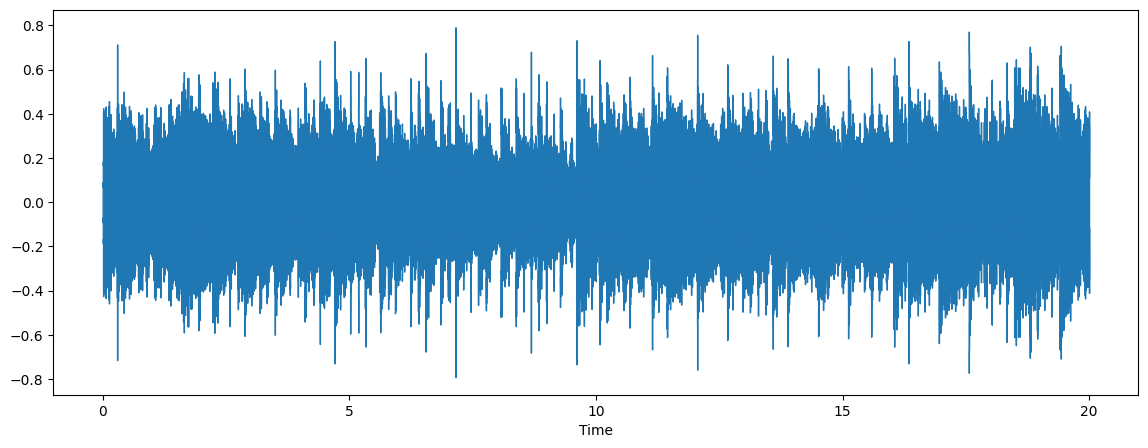

In [13]:
audio, sr = librosa.load(output_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)

ipd.Audio(sample_file)

Nice! Audio sounds close to original.

## Convert model to OpenVINO Intermediate Representation format

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via ONNX conversion. We will use `torch.onnx.export` for exporting the ONNX model from PyTorch. We need to provide initialized model's instance and example of inputs for shape inference. We will use `mo.convert_model` functionality to convert the ONNX models. The `mo.convert_model` Python function returns an OpenVINO model ready to load on the device and start making predictions. We can save it on disk for the next usage with `openvino.runtime.serialize`.

In [14]:
class FrameEncoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x: torch.Tensor):
        codes, scale = self.model._encode_frame(x)
        if not self.model.normalize:
            return codes
        return codes, scale        

In [15]:
class FrameDecoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, codes, scale=None):
        return model._decode_frame((codes, scale))

In [16]:
encoder = FrameEncoder(model)
decoder = FrameDecoder(model)

In [17]:
from openvino.tools import mo
from openvino.runtime import Core, serialize

core = Core()

OV_ENCODER_PATH = Path("encodec_encoder.xml")
if not OV_ENCODER_PATH.exists():
    torch.onnx.export(encoder, torch.zeros(1, 1, 480000), "encodec_encoder.onnx")
    encoder_ov = mo.convert_model("encodec_encoder.onnx", compress_to_fp16=True)
    serialize(encoder_ov, str(OV_ENCODER_PATH))
else:
    encoder_ov = core.read_model(OV_ENCODER_PATH)

In [18]:
OV_DECODER_PATH = Path("encodec_decoder.xml")
if not OV_DECODER_PATH.exists():
    torch.onnx.export(decoder, torch.zeros([1, 8, 1500], dtype=torch.long), "encodec_decoder.onnx", input_names=["codes", "scale"])
    decoder_ov = mo.convert_model("encodec_decoder.onnx", compress_to_fp16=True)
    serialize(decoder_ov, str(OV_DECODER_PATH))
else:
    decoder_ov = core.read_model(OV_DECODER_PATH)

## Integrate OpenVINO to EnCodec pipeline

The following steps are required for integration of OpenVINO to EnCodec pipeline:

1. Load the model to a device.
2. Define audio frame processing functions.
3. Replace the original frame processing functions with OpenVINO based algorithms.

In [19]:
device = "CPU"

compiled_encoder = core.compile_model(encoder_ov, device)
encoder_out = compiled_encoder.output(0)

compiled_decoder = core.compile_model(decoder_ov, device)
decoder_out = compiled_decoder.output(0)

In [20]:
def encode_frame(x: torch.Tensor):
    has_scale = len(compiled_encoder.outputs) == 2
    result = compiled_encoder(x)
    codes = torch.from_numpy(result[encoder_out])
    if has_scale:
        scale = torch.from_numpy(result[compiled_encoder.output(1)])
    else:
        scale = None
    return codes, scale

In [21]:
EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]


def decode_frame(encoded_frame: EncodedFrame):
    codes, scale = encoded_frame
    inputs = [codes]
    if scale is not None:
        inputs.append(scale)
    return torch.from_numpy(compiled_decoder(inputs)[decoder_out])

In [22]:
model._encode_frame = encode_frame
model._decode_frame = decode_frame

## Run EnCodec with OpenVINO

The process of running encodec with OpenVINO under hood will be the same like with the original PyTorch models.

In [23]:
fo = io.BytesIO()
compress_to_file(model, wav, fo)

In [24]:
out_file = Path("compressed_ov.ecdc")
out_file.write_bytes(fo.getvalue())

15067

In [25]:
out, out_sr = decompress_from_file(io.BytesIO(out_file.read_bytes()))

In [26]:
ov_output_file = "decopressed_ov.wav"
save_audio(out, ov_output_file, out_sr)

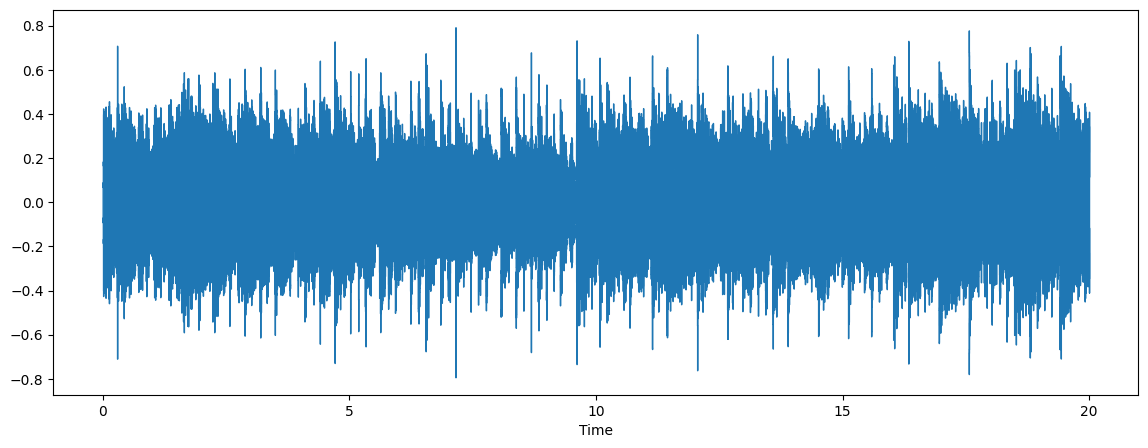

In [27]:
audio, sr = librosa.load(ov_output_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)

ipd.Audio(sample_file)